# Pose Estimation

## 1. Load Image & Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

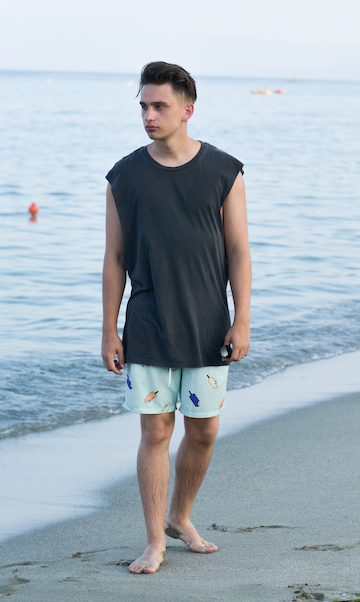

In [3]:
image = cv2.imread('/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Images/standing_person.png')

cv2_imshow(image)

In [4]:
image.shape

(602, 360, 3)

In [5]:
height = image.shape[0]
width = image.shape[1]

# https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7
image_blob = cv2.dnn.blobFromImage(image=image, 
                                   scalefactor=1/255, 
                                   size=(width, height))

- `blobFromImage()` is a function in OpenCV, which is used to preprocess images for deep learning tasks. The function takes an image as input and transforms it into a blob, which is a multi-dimensional array of image data in a format that can be consumed by deep learning models.

- Specifically, `blobFromImage()` performs the following operations on the input image:
1. Resizes the image to the specified size.
2. Subtracts the mean values from each channel of the image. This is done to center the data and improve the accuracy of the model.
3. Optionally scales the image values by a specified factor.
4. Optionally swaps the order of the channels in the image. This is done to convert the image from OpenCV's default BGR format to the RGB format commonly used in deep learning frameworks.

- The resulting blob can then be fed into a deep learning model for inference or training.

In [6]:
type(image_blob), image_blob.shape 

(numpy.ndarray, (1, 3, 602, 360))

- The first 1 is a batch size

## 2. Loading the pre-trained neural network

- Caffe Deep Learning framework: https://caffe.berkeleyvision.org/

In [7]:
prototxt_path = '/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Weights/pose_deploy_linevec_faster_4_stages.prototxt'
caffemodel_path = '/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Weights/pose_iter_160000.caffemodel'

network = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

In [8]:
network.getLayerNames()

('conv1_1',
 'relu1_1',
 'conv1_2',
 'relu1_2',
 'pool1_stage1',
 'conv2_1',
 'relu2_1',
 'conv2_2',
 'relu2_2',
 'pool2_stage1',
 'conv3_1',
 'relu3_1',
 'conv3_2',
 'relu3_2',
 'conv3_3',
 'relu3_3',
 'conv3_4',
 'relu3_4',
 'pool3_stage1',
 'conv4_1',
 'relu4_1',
 'conv4_2',
 'relu4_2',
 'conv4_3_CPM',
 'relu4_3_CPM',
 'conv4_4_CPM',
 'relu4_4_CPM',
 'conv5_1_CPM_L1',
 'relu5_1_CPM_L1',
 'conv5_1_CPM_L2',
 'relu5_1_CPM_L2',
 'conv5_2_CPM_L1',
 'relu5_2_CPM_L1',
 'conv5_2_CPM_L2',
 'relu5_2_CPM_L2',
 'conv5_3_CPM_L1',
 'relu5_3_CPM_L1',
 'conv5_3_CPM_L2',
 'relu5_3_CPM_L2',
 'conv5_4_CPM_L1',
 'relu5_4_CPM_L1',
 'conv5_4_CPM_L2',
 'relu5_4_CPM_L2',
 'conv5_5_CPM_L1',
 'conv5_5_CPM_L2',
 'concat_stage2',
 'Mconv1_stage2_L1',
 'Mrelu1_stage2_L1',
 'Mconv1_stage2_L2',
 'Mrelu1_stage2_L2',
 'Mconv2_stage2_L1',
 'Mrelu2_stage2_L1',
 'Mconv2_stage2_L2',
 'Mrelu2_stage2_L2',
 'Mconv3_stage2_L1',
 'Mrelu3_stage2_L1',
 'Mconv3_stage2_L2',
 'Mrelu3_stage2_L2',
 'Mconv4_stage2_L1',
 'Mrelu4_sta

In [9]:
len(network.getLayerNames())

127

## 2. Predict Body Points

In [10]:
network.setInput(image_blob)

output = network.forward()

In [11]:
output.shape

(1, 44, 76, 45)

The forward() method returns a 4D NumPy array of shape (N, C, H, W), where:

- N is batch size
- C is the number of classes in the model (which means the number of categories of body points)
- H is the height of the output feature map
- W is the width of the output feature map

In [12]:
feature_map_height = output.shape[2]
feature_map_width = output.shape[3]

In [13]:
num_body_points = 15  # number of body points except for background in MPII model 
body_points = []
confidence_threshold = 0.1

for body_point_idx in range(num_body_points):
    confidence_map = output[0, body_point_idx, :, :]
    _, max_confidence, _, max_position = cv2.minMaxLoc(confidence_map)

    # scaling x, y position
    x = int((image.shape[1] * max_position[0]) / feature_map_width)
    y = int((image.shape[0] * max_position[1]) / feature_map_height)

    if max_confidence > confidence_threshold:
        cv2.circle(image, (x, y), 5, (0, 0, 255), thickness=-1)
        cv2.putText(image, f'{body_point_idx}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0))
        body_points.append((x, y))
    else:
        body_points.append(None)

In [14]:
body_points

[(152, 63),
 (168, 134),
 (120, 166),
 (112, 253),
 (104, 324),
 (224, 166),
 (232, 245),
 (240, 316),
 (144, 332),
 (152, 419),
 (152, 530),
 (200, 332),
 (200, 427),
 (176, 506),
 (168, 253)]

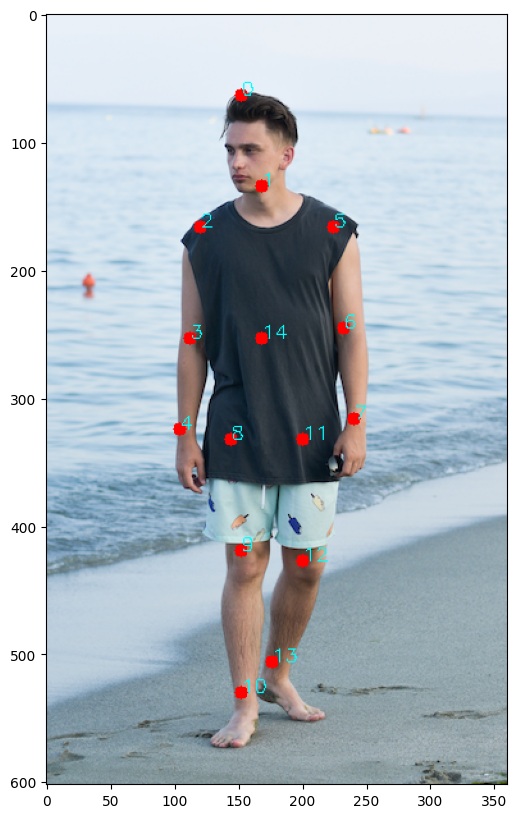

In [15]:
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

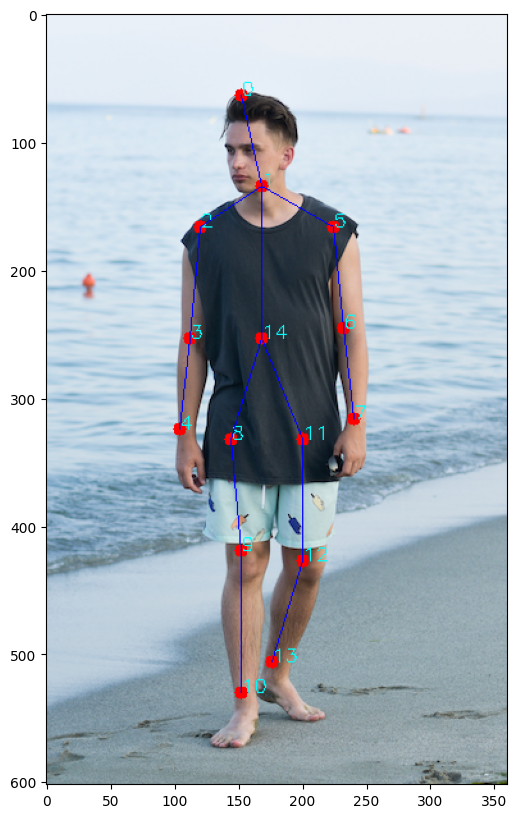

In [16]:
point_connections = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],[1,14],
                     [14,8], [8,9], [9,10], [14,11], [11,12], [12,13]]
                     
for connection in point_connections:
    connection_start = connection[0]
    connection_end = connection[1]
    if body_points[connection_start] and body_points[connection_end]:
        cv2.line(image, body_points[connection_start], body_points[connection_end], (255, 0, 0))

plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));